In [1]:
import os
import re
import numpy as np
from tqdm import tqdm
import json
import copy

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
# session = tf.compat.v1.Session(config=config)
# print(session)

In [3]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 8
NUM_EPOCHS = 2
MAX_LEN = 256
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [4]:
# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

## Data Prep

In [5]:
train_data = pd.read_excel(DATA_IN_PATH+'/train_0222.xlsx', header=0)
test_data = pd.read_excel(DATA_IN_PATH+'/test_0222.xlsx', header=0)

In [6]:
print(train_data.shape)
train_data.head(10)

(75602, 3)


,Unnamed: 0,sentens,label
0,11944,카카오톡 선물 하기 플랫폼 을 통해 커피 쿠폰 처럼 쉽게 구매 ∙ 선물 하고 받은 ...,CE-B O O O O O O O O O O O O O O O O O O O O O...
1,65973,디지털타임스 박정일 기자 내년 에는 미국 의 신 행정부 출범 에 따른 각국 의 환경...,O O O O O LOC-B O O O O O O O O O O O O O O O ...
2,5233,비 은행 부문 기여 도 는 . 로 전 년 동기 . 에 비해 . 포인트 가 늘었다 .,O O O O O O O O O O O O O O O CO-B O O O
3,42429,관계자 는 은 산업 기술 혁신 체계 디지털 전환 가속 화 와 효율 적 성과 창 출을...,O O O O O CO-B O O O CO-B O O O O O O O O O O ...
4,33753,법사위 는 민간 데이터 센터 를 국가 재난 관리 시설 로 지정 하는 방송통신 발전 ...,CO-B O O TE-B O O O O O O O O O O O O O O O O ...
5,92371,사람 이 사업 적 목표 를 달 성하 는 데 가장 중요 한 원동력 이라는 점 을 강조...,O O O O O O CO-B O O O O O O O O O O O O O O O...
6,8402,최근 언론 을 통해 접 하시는 실리콘밸리 모습 이 어떻게 비치 는 지 모르겠습니다 .,O O O O O O CO-B CO-B O O O O O O O
7,39289,일 요미우리신문 에 따르면 미즈 호 은행 은 내년 월부 터 세 미만 소비자 가 신규...,O O O O CO-B O O O O O O O O O O O O O O O O O...
8,37805,또 혁신 성장 전력 품질 포용 경제 미래 역량 등 대 혁신 분야 를 축 으로 중소기...,O CO-B O O O O O CO-B O O O CO-B O O O O O O O...
9,85901,최 기 영 과기 정통부 장관 은 이번 에 수립 한 정책 을 속도 감 있게 추진 할 ...,O O O O O O O O O O O O O O O O O O O O O O O ...


In [7]:
# sentens 길이 상/하위 20% 제외
train_data = train_data[(train_data['sentens'].apply(len)>84) & (train_data['sentens'].apply(len)<MAX_LEN)].reset_index(drop=True)
test_data = test_data[(test_data['sentens'].apply(len)>84) & (test_data['sentens'].apply(len)<MAX_LEN)].reset_index(drop=True)

In [8]:
# sanity check
for i in range(len(train_data)):
  if len(train_data['sentens'][i].split()) != len(train_data['label'][i].split()):
    print("exception occurred!")

In [9]:
print(test_data.shape)
test_data.head()

(8091, 3)


,Unnamed: 0,sentens,label
0,29,지 원단 은 서류 전형 을 거쳐 선발 하며 참여 를 원하 는 경우 오는 일 까지 재...,O O O O O O O O O O O CO-B O CO-B O O O O O O ...
1,38,간편 결제 진 흥원 은 제로 페이 를 통한 신속 한 바 우 처 지원이 이뤄 지도 록...,O O CO-B O O O O O O O O O O O O O O O O O O O...
2,45,회사 측은 불 필요 한 감시 대신 썸네일 형 체 크리스트 를 통해 근무 자 불편 사...,O O O O O O O O O O O O O O O O O O O O O O O ...
3,52,김정태 하나 금융 은 코로나 위기 로 불 확실성 이 심화 된 지금 변화 파고 를 넘...,O CO-B O O O O O O O O O O O O O O O O O CO-B ...
4,67,기존 프리미엄 서비스 인 북 클럽 생각 라이브러리 의 독서 콘텐츠 와 웅진 스마트 ...,O O O CO-B O O O O O O O O CO-B O O O O O O O ...


In [10]:
# sanity check
for i in range(len(train_data)):
  if len(train_data['sentens'][i].split()) != len(train_data['label'][i].split()):
    print("exception occurred!")

In [11]:
train_sentences = train_data.sentens.tolist()
train_labels = train_data.label.tolist()

train_ner_dict = {"sentence": train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

test_sentences = test_data.sentens.tolist()
test_labels = test_data.label.tolist()

test_ner_dict = {"sentence": test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

print("개체명 인식 학습 데이터 개수: {}".format(len(train_ner_df)))
print("개체명 인식 테스트 데이터 개수: {}".format(len(test_ner_df)))

개체명 인식 학습 데이터 개수: 32277
개체명 인식 테스트 데이터 개수: 8091


In [12]:
ner_labels=['UNK',
 'O',
 'BM-B',
 'BM-I',
 'CO-B',
 'CO-I',
 'CE-B',
 'CE-I',
 'OE-B',
 'OE-I',
 'OI-B',
 'OI-I',
 'PO-B',
 'PO-I',
 'TE-B',
 'TE-I',
 'CT-B',
 'CT-I',
 'ECT-B',
 'EVT-I',
 'LOC-B',
 'LOC-I',
 'ORG-B',
 'ORG-I',
 'ST-B',
 'ST-I',
 'NUM-B',
 'NUM-I']

In [13]:
print("개체명 인식 레이블 개수: {}".format(len(ner_labels)))
ner_labels

개체명 인식 레이블 개수: 28


['UNK',
 'O',
 'BM-B',
 'BM-I',
 'CO-B',
 'CO-I',
 'CE-B',
 'CE-I',
 'OE-B',
 'OE-I',
 'OI-B',
 'OI-I',
 'PO-B',
 'PO-I',
 'TE-B',
 'TE-I',
 'CT-B',
 'CT-I',
 'ECT-B',
 'EVT-I',
 'LOC-B',
 'LOC-I',
 'ORG-B',
 'ORG-I',
 'ST-B',
 'ST-I',
 'NUM-B',
 'NUM-I']

## BERT tokenizer 설정

In [14]:
# 버트 토크나이저 설정

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case = False)

pad_token_id = tokenizer.pad_token_id # 0
pad_token_label_id = 0
cls_token_label_id = 0
sep_token_label_id = 0

In [15]:
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        truncation=True,
        add_special_tokens = True, #'[CLS]'와 '[SEP]' 추가
        max_length = MAX_LEN,           # 문장 패딩 및 자르기 진행
        pad_to_max_length = True,
        return_attention_mask = True   # 어탠션 마스크 생성
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] 
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

def convert_label(words, labels_idx, ner_begin_label, max_seq_len):
            
    tokens = []
    label_ids = []

    for word, slot_label in zip(words, labels_idx):

        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            word_tokens = ['UNK']
        tokens.extend(word_tokens)
        
        # 슬롯 레이블 값이 Begin이면 I로 추가
        if int(slot_label) in ner_begin_label:
            label_ids.extend([int(slot_label)] + [int(slot_label) + 1] * (len(word_tokens) - 1))
        else:
            label_ids.extend([int(slot_label)] * len(word_tokens))
  
    # [CLS] and [SEP] 설정
    special_tokens_count = 2
    if len(label_ids) > max_seq_len - special_tokens_count:
        label_ids = label_ids[: (max_seq_len - special_tokens_count)]

    # [SEP] 토큰 추가
    label_ids += [sep_token_label_id]

    # [CLS] 토큰 추가
    label_ids = [cls_token_label_id] + label_ids
    
    padding_length = max_seq_len - len(label_ids)
    label_ids = label_ids + ([pad_token_label_id] * padding_length)
    
    return label_ids

In [16]:
# sanity check
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]
ner_begin_label_string = [ner_labels[label_index] for label_index in ner_begin_label]

print(ner_begin_label)
print(ner_begin_label_string)

[2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
['BM-B', 'BM-I', 'CO-B', 'CE-B', 'OE-B', 'OI-B', 'PO-B', 'TE-B', 'CT-B', 'ECT-B', 'LOC-B', 'ORG-B', 'ST-B', 'NUM-B']


In [17]:
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]

def create_inputs_targets(df):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    label_list = []

    for i, data in enumerate(df[['sentence', 'label']].values):
        sentence, labels = data
        words = sentence.split()
        labels = labels.split()
        labels_idx = []
        
        for label in labels:
            labels_idx.append(ner_labels.index(label) if label in ner_labels else ner_labels.index("UNK"))
        #print(labels_idx)
        assert len(words) == len(labels_idx)

        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)
        convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_list.append(convert_label_id)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_list = np.asarray(label_list, dtype=int) #레이블 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)
    
    return inputs, label_list

In [18]:
train_inputs, train_labels = create_inputs_targets(train_ner_df)

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2149: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
test_inputs, test_labels = create_inputs_targets(test_ner_df)

## Define model

In [20]:
class TFBertNERClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertNERClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name="ner_classifier")

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
                
        sequence_output = self.dropout(sequence_output, training=training)
        logits = self.classifier(sequence_output)
        

        return logits

In [21]:
ner_model = TFBertNERClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=len(ner_labels))

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## utils

In [22]:
def compute_loss(labels, logits):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )

    # 0의 레이블 값은 손실 값을 계산할 때 제외
    active_loss = tf.reshape(labels, (-1,)) != 0
        
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list(logits)[2])), active_loss)
        
    labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)
    
    return loss_fn(labels, reduced_logits)

In [23]:
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def compute_f1_pre_rec(self, labels, preds):

        return {
            "precision": precision_score(labels, preds, suffix=True),
            "recall": recall_score(labels, preds, suffix=True),
            "f1": f1_score(labels, preds, suffix=True)
        }


    def show_report(self, labels, preds):
        return classification_report(labels, preds, suffix=True)
        
    def on_epoch_end(self, epoch, logs=None):

        results = {}
        
        pred = self.model.predict(self.x_eval)
        label = self.y_eval
        pred_argmax = np.argmax(pred, axis = 2)

        slot_label_map = {i: label for i, label in enumerate(ner_labels)}

        out_label_list = [[] for _ in range(label.shape[0])]
        preds_list = [[] for _ in range(label.shape[0])]

        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if label[i, j] != 0:
                    out_label_list[i].append(slot_label_map[label[i][j]])
                    preds_list[i].append(slot_label_map[pred_argmax[i][j]])
                    
        result = self.compute_f1_pre_rec(out_label_list, preds_list)
        results.update(result)

        print("********")
        print("F1 Score")
        for key in sorted(results.keys()):
            print("{}, {:.4f}".format(key, results[key]))
        print("\n" + self.show_report(out_label_list, preds_list))
        print("********")

f1_score_callback = F1Metrics(test_inputs, test_labels)

## Train  
**MAKE SURE KERNEL DON'T DIE!!!**  
F12(개발자도구) → Console 탭 → 해당코드 복사 후 Enter  
`function ClickConnect() {`  
`  console.log('Working')`  
`  document`  
`    .querySelector('#top-toolbar > colab-connect-button')`  
`    .shadowRoot.querySelector('#connect')`  
`    .click()`  
`}`  
  
`setInterval(ClickConnect, 60000)`  

In [24]:
train_inputs[2].shape

(32277, 256)

In [25]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(3e-5)
# ner_model.compile(optimizer=optimizer, loss=compute_loss, run_eagerly=True)
ner_model.compile(optimizer=optimizer, loss=compute_loss)

In [26]:
model_name = "dx_bert_ner_cased"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

history = ner_model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, callbacks=[cp_callback, f1_score_callback])

print(history.history)

data_out/KOR\dx_bert_ner_cased -- Folder already exists 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4035/4035 [==============================] - 1048s 255ms/step - loss: 0.1499
********
F1 Score
f1, 0.9595
precision, 0.9508
recall, 0.9684

              precision    recall  f1-score   supp

In [27]:
# print(checkpoint_path)
ner_model.save_weights(checkpoint_path)

In [28]:
print(checkpoint_path)

data_out/KOR\dx_bert_ner_cased\weights


In [36]:
ner_model.load_weights(checkpoint_path)

## Result

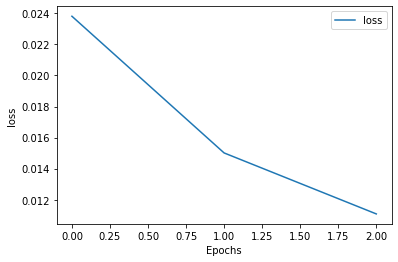

In [43]:
plot_graphs(history, 'loss')

In [44]:
def ner_evaluation_predict(sentence, MAX_LEN):
    #model = create_model()
    #ner_model = model.load_weights("check_point 절대경로")

    input_ids = []
    attention_masks = []
    token_type_ids = []
    #label_list = []
    words = sentence.split(' ')

    input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)
    #convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    #label_list.append(convert_label_id)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    #label_list = np.asarray(label_list, dtype=int) #레이블 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)

    predict = ner_model.predict(inputs)
    #print(predict)
    pred_argmax = np.argmax(predict, axis = -1)
    #print(pred_argmax[0])
    #print(input_ids)
    result_labels = []
    result_words = []
    
    for pred in pred_argmax[0]:
        result_labels.append(ner_labels[pred])
        
# for word_ids in pred_argmax[0]:
    #print(pred_argmax[0])
    temp_lst = tokenizer.convert_ids_to_tokens(input_ids[0])
    #print(temp_lst[0])
    result_words = tokenizer.convert_tokens_to_string(temp_lst)
#     print(temp_lst, len(temp_lst))
#     print(result_labels, len(result_labels))
#     print(result_words, len(result_words))
    start_idx=temp_lst.index('[CLS]')+1
    end_idx=temp_lst.index('[SEP]')
    
    words=temp_lst[start_idx:end_idx]
    labels = result_labels[start_idx:end_idx]
    
    #print(words)
    #print(labels)
    r_label_idx_lst=[]
    
    for i in range(len(labels)):
        #print(labels[i])
        b_lbl =[]
        if ('B' in labels[i]) or ('I' in labels[i]):
            r_label_idx_lst.append(i)
            
            if ('B' in labels[i]):
                b_lbl.append(i)
                print(b_lbl)

    w_string = [words[label_index] for label_index in r_label_idx_lst]
    r_string = [labels[label_index] for label_index in r_label_idx_lst]
    print(r_label_idx_lst)
    print(r_string)
    print(w_string)

In [46]:
# ner_evaluation_predict("기사예시문장", 256)

In [45]:
# 특정 태그가 나오는 문장만 뽑아서 보기
test_dev = test_data[test_data['label'].apply(lambda x : 'OI-B' in x)].reset_index(drop=True)
for i in range(len(test_dev)):
  print(test_dev['sentens'][i])
  print(test_dev['label'][i])
  ner_evaluation_predict(test_dev['sentens'][i], 512)
  print()

에이 젠 글로벌 은 우리은행 현대카드 우리카드 삼성 화재 등 국내 우수 금융 회사 들의 인공 지능 디지털 전환 프로젝트 를 수행 했으며 동남아시아 시장 에서 금융 회사 와 현지 기업 들을 연결 해 뱅킹 서비스 를 제공 하는 모델 로 금융 모델 을 선도 하고 있다 . 에이 젠 글로벌 은 네이버 클라우드 와 협업 하여 동남아시아 시장 에 집중 할 수 있는 금융 모델 파트너십 을 진행 하고 있다 .
O CO-B O O O CO-B O CO-B O O O CO-B O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O CO-B O O CO-B O O O O O O O O O CO-B O O O OI-B O O O O O
[2]
[11]
[18]
[25]
[92]
[97]
[118]
[124]
[2, 11, 12, 13, 18, 19, 25, 26, 92, 97, 98, 99, 118, 124, 125, 126, 127]
['CO-B', 'CO-B', 'CO-I', 'CO-I', 'CO-B', 'CO-I', 'CO-B', 'CO-I', 'CO-B', 'CO-B', 'CO-I', 'CO-I', 'CO-B', 'OI-B', 'OI-I', 'OI-I', 'OI-I']
['젠', '현대', '##카', '##드', '삼', '##성', '우', '##수', '젠', '네', '##이', '##버', '수', '파', '##트', '##너', '##십']

이승환 기자 국내 양대 데이터 거래소 인 한국 데이터 거래소 대표 박재현 와 금융 보안 원 원장 김영기 의 금융데이터거래소 가 데이터 유통 과 활용 혁신 을 위 한 업무협약 을 일 체결 했다 .
O O O O TE-B O CO-B O TE-B O O O O O O CO-B O O O O O TE-B O O O CO-B O O O OI-B O O EVT-B O O


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[8]
[13]
[15]
[30]
[45]
[52]
[57]
[8, 9, 13, 15, 16, 30, 45, 46, 52, 53, 57, 58, 59, 60]
['TE-B', 'TE-I', 'CO-B', 'TE-B', 'TE-I', 'CO-B', 'TE-B', 'TE-I', 'CO-B', 'CO-I', 'OI-B', 'OI-I', 'OI-I', 'OI-I']
['데', '##이터', '인', '데', '##이터', '원', '데', '##이터', '혁', '##신', '업', '##무', '##협', '##약']

이를 위해 하나 금융 은 지난 일 두산 그룹 과 업무협약 을 맺고 두산 그룹 이 진행 하는 풍력 수소 연료 에너지 등 그린에너지 산업 에 직 간접 적 으로 금융 지원 을 하기로 했다 .
O O CO-B O O O O CO-B O O OI-B O O CO-B O O O O O O O O O CO-B O O O O O O O CO-B O O O O
[2]
[10]
[15]
[22]
[40]
[55]
[2, 3, 10, 11, 15, 16, 17, 18, 22, 23, 40, 41, 42, 43, 44, 55, 56]
['CO-B', 'CO-I', 'CO-B', 'CO-I', 'OI-B', 'OI-I', 'OI-I', 'OI-I', 'CO-B', 'CO-I', 'CO-B', 'CO-I', 'CO-I', 'CO-I', 'CO-I', 'CO-B', 'CO-I']
['하', '##나', '두', '##산', '업', '##무', '##협', '##약', '두', '##산', '그', '##린', '##에', '##너', '##지', '지', '##원']

올해 시스템반도체 개 바이오 개 미래 차 개 등 모두 개 기업 을 전문가 와 국민 참여 단 평가 를 통해 선정 사업화 자금 과 기술 개발 정책 자금 을 맞춤 형 으로 지원 하고 있다 .
O TE-B O O O CO-B O O O O O O O O O O O O O O O O OI-B O O O O O O O 